In [13]:
# Import the required libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [14]:
# Create variables to the folders

train_folder = "./archive/Train"
test_folder = "./archive/Test"

train_class_folders = os.listdir(train_folder)

# Dictionary for naming the class types

classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}




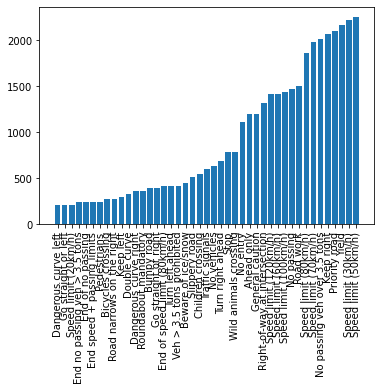

In [15]:
# Get number of instances per class and visualize the data

train_numberOfInstancesPerClass = []
class_names = []

for folder in train_class_folders:
    train_files = os.listdir(train_folder + '/' + folder)
    train_numberOfInstancesPerClass.append(len(train_files))
    class_names.append(classes[int(folder)])

pairs = zip(train_numberOfInstancesPerClass, class_names)
pairs = sorted(pairs)
tuples = zip(*pairs)
train_numberOfInstancesPerClass, class_names = [
    list(tuple) for tuple in tuples]

plt.bar(class_names, train_numberOfInstancesPerClass)
plt.xticks(class_names, rotation='vertical')
plt.show()

In [16]:
# Creating image data and label arrs for training/validation sets

images = []
labels = []

for imgClass in range(len(classes)):
    imgFolder_path = train_folder + "/" + str(imgClass)
    imgFolder = os.listdir(imgFolder_path)

    for img in imgFolder:
        image = cv2.imread(imgFolder_path + "/" + img)  # get an image
        image = Image.fromarray(image, 'RGB')
        image = image.resize((32, 32))  # resize all images to same size
        images.append(np.array(image))
        labels.append(imgClass)

images = np.array(images)
labels = np.array(labels)

In [17]:
# Shuffle the dataset

shuffle_indexes = np.arange(images.shape[0])
np.random.shuffle(shuffle_indexes)
images = images[shuffle_indexes]
labels = labels[shuffle_indexes]

In [18]:
# Create the training and validation sets 

x_train, x_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.3, shuffle=True)

x_train = x_train/255
x_val = x_val/255  # !!!! WHY?

# Convert classes to one-hot vectors
y_train = keras.utils.to_categorical(y_train, len(classes))
y_val = keras.utils.to_categorical(y_val, len(classes))

In [19]:
# Load the test data and create the test sets

test_csv = pd.read_csv("./archive/Test.csv")

labels = test_csv['ClassId'].values  # y_test
images = test_csv['Path'].values
x_test = []

for imagePath in images:
    image = cv2.imread('./archive/' + imagePath)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((32, 32))
    x_test.append(np.array(image))

x_test = np.array(x_test)
x_test = x_test/255

In [20]:
# Create the LeNet5 Model

lenet5_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh',
                        input_shape=x_train[0].shape, padding='same'), 
    keras.layers.AveragePooling2D(),  
    keras.layers.Conv2D(16, kernel_size=5, strides=1,
                        activation='tanh', padding='valid'),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(120, kernel_size=5, strides=1,
                        activation='tanh', padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(84, activation='tanh'),
    keras.layers.Dense(43, activation='softmax')  # Output layer. 43 since since there are 43 possible classes.
])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 480)               0

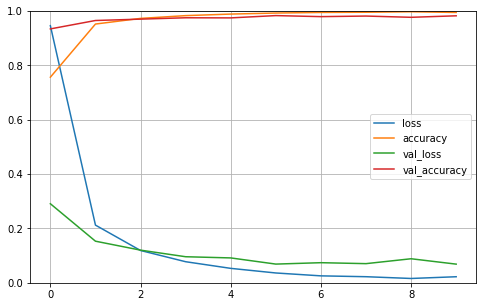

In [21]:
lenet5_model.compile(
    optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

lenet5_model.summary()

print("x tr: " + str(x_train.shape))
print("y tr: " + str(y_train.shape))
print("x val: "+str(x_val.shape))
print("y val: "+str(y_val.shape))

history = lenet5_model.fit(x_train, y_train, epochs=10,
                           validation_data=(x_val, y_val))

# Show the graph for training and validation.

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [22]:
# Make the prediction with test data

pred = lenet5_model.predict(x_test)
pred = np.argmax(pred, axis=1)

# Measure the accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred)*100)

395/395 [==============================] - 4s 9ms/step
Test Data accuracy:  91.60728424386382
